# Import and defining classes

In [1]:
    # === Uncomment to clone and access repo 
!git clone https://github.com/timmytonga/gans-vi 
%cd gans-vi
# !git pull
!ls

Cloning into 'gans-vi'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 126 (delta 77), reused 60 (delta 26), pack-reused 0
Receiving objects: 100% (126/126), 38.92 KiB | 9.73 MiB/s, done.
Resolving deltas: 100% (77/77), done.
/content/gans-vi
dcgan_models.py      inception_score.py		 train_wgan_gp_extra.py
extraSGD.py	     README.md			 train_wgan_gp.py
fit_extrapastsgd.py  resnet_models.py		 utils.py
fit_extrasgd.py      train_wgan_gp_extrapast.py  wgan_gp_loss.py


In [2]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, random_split
# torchvision
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms


from dcgan_models import Generator, Discriminator
from wgan_gp_loss import disc_loss_wgan_gp, gen_loss_wgan_gp
from utils import make_noise, show_tensor_images, get_cur_timestamp


from tqdm.auto import tqdm  # for visualizing progress per epoch
import time


### [Optional] Setting up Google Drive for Loading and Saving checkpoints

In [3]:
# first, setting up check-point directory (we want this to be on a permanent storage like google drive or local)
# first mount the google drive here, hello
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!ls /content/drive/'My Drive'/datafor6140

 DCGAN_alt_batchNorm_Adam.pt	        DCGAN_extrapast_noNorm_SGD.pt
 DCGAN_alt_batchNorm_extraAdam.pt       DCGAN_extrapast_ourNorm_SGD.pt
 DCGAN_alt_batchnorm_extrapastAdam.pt   DCGAN_sim_BatchNorm_Adam.pt
 DCGAN_alt_batchNorm_SGD.pt	        DCGAN_sim_BatchNorm_SGD.pt
 DCGAN_alt_noNorm_extraAdam.pt	        DCGAN_sim_noNorm_Adam_old.pt
 DCGAN_alt_noNorm_SGD.pt	        DCGAN_sim_noNorm_Adam.pt
 DCGAN_alt_norm_Adam.pt		        DCGAN_sim_noNorm_SGD_old.pt
 DCGAN_alt_norm_extraAdam.pt	        DCGAN_sim_noNorm_SGD.pt
 DCGAN_alt_ourNorm_SGD.pt	        DCGAN_sim_ourNorm_Adam.pt
 DCGAN_extra_noNorm_SGD_old.pt	        DCGAN_sim_ourNorm_SGD.pt
 DCGAN_extra_noNorm_SGD.pt	        DCGAN_simul_extraadam_batchnorm.pt
 DCGAN_extrapast_BatchNorm_SGD.pt      'Notebooks for training code'
 DCGAN_extrapast_noNorm_SGD_old.pt      Resnet_alt_Norm_extraAdam.pt


# Get Ready to Do the things

## Set up Loading and Models


### Initialize Files and Models

In [73]:
# =========================================================================== #
#                  FIRST, MUST MAKE SURE PATHS ARE CORRECT                    #
# =========================================================================== #
CHECKPOINT_PATH='/content/drive/My Drive/datafor6140/'
SAVE_MODEL_PATH="/content/drive/My Drive/Colab Notebooks/cs6140/gan_model/"
DISC_PATH = SAVE_MODEL_PATH + 'disc_weight.pth'
GEN_PATH = SAVE_MODEL_PATH + 'gen_weight.pth'


# =========================================================================== #
#                  SET ANY CHECKPOINT FILE HERE (ignore if no checkpoint)     #
# =========================================================================== #
CHECKPOINTFILENAME = 'DCGAN_alt_batchNorm_Adam.pt'
CHECKPOINTFILEPATH = CHECKPOINT_PATH + CHECKPOINTFILENAME  # change the last part
ENABLE_CHECKPOINT = True

In [74]:
# =========================================================================== #
#                  GET MODELS                                                 #
# =========================================================================== #
from dcgan_models import Discriminator, Generator
                   # do we want to do WGAN or WGAN-GP?
wgan_gp = False
                   # true for no batchnorm, false for batchnorm

device = 'cpu'
if torch.cuda.is_available():  # use gpu if available
	device = 'cuda'


gen = Generator().to(device)
gen2 = Generator().to(device)
disc = Discriminator(wgan_gp=wgan_gp).to(device)
disc2 = Discriminator(wgan_gp=wgan_gp).to(device)

# =========================================================================== #
#                  SET OPTIMIZERS HERE                                        #
# =========================================================================== #
import pytz
from datetime import datetime

# define the Adam optimizers
# Use arbitrary lr: no training
gen_opt = torch.optim.SGD(gen.parameters(), lr=0.001)
disc_opt = torch.optim.SGD(disc.parameters(), lr=0.0011)

# define SGD 
# gen_opt = torch.optim.SGD(gen.parameters(), lr=lr)
# disc_opt = torch.optim.SGD(disc.parameters(), lr=lr)

# =========================================================================== #
#                  SET LOSS FUNCTIONS FOR FITTING                             #
# =========================================================================== #
disc_loss_fn = disc_loss_wgan_gp
gen_loss_fn = gen_loss_wgan_gp

def get_cur_timestamp():
	tz_NY = pytz.timezone('America/New_York')
	dateTimeObj = datetime.now(tz_NY)
	return dateTimeObj.strftime("[%d-%b-%Y(%H:%M)]")

get_cur_timestamp()

'[14-Dec-2020(17:01)]'

### Setting up hyperparameters and environment variables

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


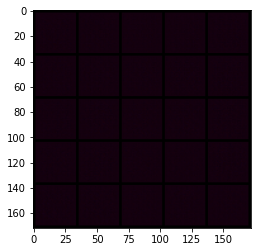

In [75]:
# =========================================================================== #
#                   HYPERPARAMETERS AND TRAINING DATA                         #
# =========================================================================== #
z_dim = 128
lr = 0.00002      # learning rate
if wgan_gp:       # according to varineq paper
	lr = 0.0001
beta_1 = 0.5      # first moment's momentum (ADAM hyperparam)
beta_2 = 0.9      # second moment's momentum
weight_clipping = 0.01
c_lambda = 10     # for gradient penalty
batch_size = 64

# get data and loader
transform_train = transforms.Compose([
	# transforms.RandomHorizontalFlip(),
	transforms.ToTensor(),
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


trainset = DataLoader(CIFAR10(root='.', download=True, transform=transform_train), batch_size=batch_size, shuffle=True)


# before training initialize weight
def weights_init(m):
	if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
		torch.nn.init.normal_(m.weight, 0.0, 0.02)
	if isinstance(m, nn.BatchNorm2d):
		torch.nn.init.normal_(m.weight, 0.0, 0.02)
		torch.nn.init.constant_(m.bias, 0)
	
def weights_init_zero(m):
	if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
			torch.nn.init.constant_(m.weight, 0.0)
	if isinstance(m, nn.BatchNorm2d):
			torch.nn.init.constant_(m.weight, 0.0)
			torch.nn.init.constant_(m.bias, 0.0)


gen = gen.apply(weights_init)
disc = disc.apply(weights_init)
gen2 = gen2.apply(weights_init_zero)
disc2 = disc2.apply(weights_init_zero)

show_tensor_images(gen(make_noise(25, z_dim, device=device)), )

### Load Checkpoint

In [76]:
loadcheckptpath = CHECKPOINTFILEPATH

if loadcheckptpath is not None:  # we were provided with checkpt. Load and resume
  print(f"========= Checkpoint found! Resuming training from last checkpoint at ======== \n{loadcheckptpath}")
  print("Loading checkpoint...")
  checkpoint = torch.load(loadcheckptpath, map_location=torch.device('cpu'))
  print("Checkpoint loaded successfully! Info:")
  last_epoch = checkpoint['epoch'] + 1
  print(f"\tLast epoch: {last_epoch - 1}")
  disc.load_state_dict(checkpoint['disc_state_dict'])
  gen.load_state_dict(checkpoint['gen_state_dict'])
  disc2.load_state_dict(checkpoint['disc2_state_dict'])
  gen2.load_state_dict(checkpoint['gen2_state_dict'])
  disc_opt.load_state_dict(checkpoint['disc_opt_state_dict'])
  gen_opt.load_state_dict(checkpoint['gen_opt_state_dict'])
  print(f"\tLoaded discriminator and generator's old weight and state_dict")
  generator_losses = checkpoint['generator_losses']
  disc_losses = checkpoint['disc_losses']
  gen2_losses = checkpoint['gen2_losses']
  disc2_losses = checkpoint['disc2_losses']
  print(f"\tLoaded losses history.")
  step = checkpoint['step']
  print(f"\tLast step: {step}")
  img_history = checkpoint['img_history']
  inception_scores = checkpoint['inception_scores']
  avgmodel_image_history = checkpoint['avgmodel_image_history'] 
  avgmodel_inception_scores = checkpoint['avgmodel_inception_scores'] 
  print("Loaded img_history and inception_scores")
  print("===================== FINISHED LOADING LAST CHECKPOINT. TRAINING ===========")
else:
  print("Checkpoint not found. Below is the first image with the validation noise.")
  firstimg = gen(validation_noise)
  
  show_tensor_images(firstimg, unnorm_mean = (0.5, 0.5, 0.5), unnorm_var=(0.5, 0.5, 0.5))
  img_history += [firstimg]

disc.eval()
gen.eval()
gen2.eval()
disc2.eval()

========= Checkpoint found! Resuming training from last checkpoint at ======== 
/content/drive/My Drive/datafor6140/DCGAN_alt_batchNorm_Adam.pt
Loading checkpoint...
Checkpoint loaded successfully! Info:
	Last epoch: 500
	Loaded discriminator and generator's old weight and state_dict
	Loaded losses history.
	Last step: 391782
Loaded img_history and inception_scores
===================== FINISHED LOADING LAST CHECKPOINT. TRAINING ===========


Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (final_layer): Linear(in_features=4096, out_features=1, bias=True)
)

# Do The Things

## Vis

### Set up normalization

In [77]:
options = ['ourNorm','noNorm','Norm','batchNorm']
OPTION = 'batchNorm'

if isinstance(OPTION, str):
  idx = -1
  for i in range(len(options)):
    if options[i] == OPTION:
      idx = i
  if idx < 0:
    OPTION = 0
  else:
    OPTION = idx

if OPTION == 0:
  unnorm_means = (0.4914, 0.4822, 0.4465)
  unnorm_vars =(0.2023, 0.1994, 0.2010)
elif OPTION == 1:
  unnorm_means = (0,0,0)
  unnorm_vars = (1,1,1)
elif OPTION == 2:
  unnorm_means = (0.5,0.5,0.5)
  unnorm_vars = (0.5,0.5,0.5)
else:
  unnorm_means = (0.5,0.5,0.5)
  unnorm_vars = (0.5,0.5,0.5)

### Smoothing and Modified "show_tensor_images"


In [40]:
# smooths vals by averaging each val with its 'smoothness' closest vals in each
# direction. Does as-smooth-as-possible (balanced) for vals near ends of 'vals'
def smooth_vals(vals, smoothness):
  div_smooth = (2*smoothness) + 1
  smoothness_range = (2 * smoothness) + 1
  new_vals = []
  val_len = len(vals)
  temp_val = 0
  # smooth low end
  for i in range(0,smoothness+1):
    new_vals.append(sum(vals[0:2*i+1]) / (2 * i + 1))
  # smooth middle
  temp_val = sum(vals[0:2*smoothness+1])
  for i in range(smoothness + 1, val_len - smoothness - 1):
    temp_val = temp_val + (vals[i + smoothness])
    temp_val = temp_val - (vals[i - smoothness - 1])
    new_vals.append(temp_val / smoothness_range)
  # smooth high end
  for i in range(smoothness-1,-1,-1):
    new_vals.append(sum(vals[val_len - 1 - (2 * i):val_len]) / (2 * i + 1))
  return new_vals
  
from torchvision.utils import make_grid

SHOW_CONST = 1/1.4
def my_show_tensor_images(image_tensor, num_cols=5, num_rows=5, unnorm_mean = (0,0,0), unnorm_var = (1,1,1)):
  """
  Function for visualizing images: Given a tensor of images, number of images, and
  size per image, plots and prints the images in an uniform grid.
  """
  num_images = num_cols * num_rows
  plt.figure(figsize=(num_rows * SHOW_CONST,num_cols * SHOW_CONST))
  var = torch.tensor(unnorm_var).view(1, 3, 1, 1)
  mean = torch.tensor(unnorm_mean).view(1, 3, 1, 1)
  image_unflat = image_tensor.detach().cpu()
  image_unflat = image_unflat.mul_(var).add_(mean)
  image_grid = make_grid(image_unflat[:num_images], nrow=num_rows)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())

### Vis: Epoch data (same images across epochs, IS, smooth losses)

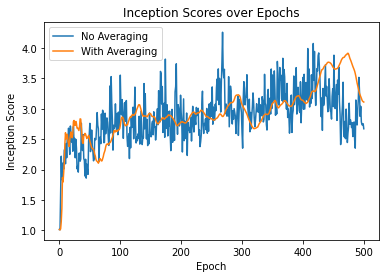

Max. IS without averaging: 4.259187921052617
Max. IS with averaging: 3.9141186387905638


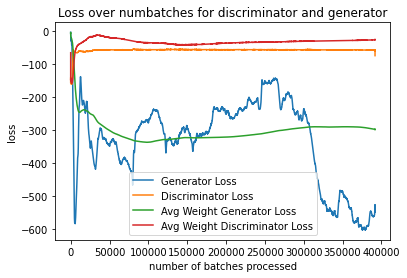

Without averaging:
With averaging:


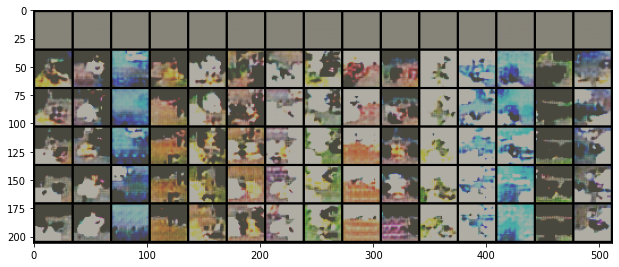

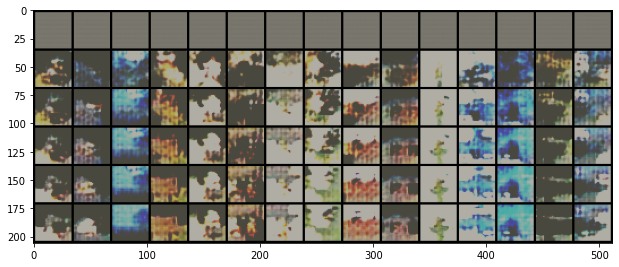

In [ ]:
smoothness = 1
epochs = [0,100,200,300,400,499]
n_images = 15

# show the IS graphs
# show the loss graphs with smoothing
# also show 5 random images from the epochs in the list 'epochs'
loss_smoothness = smoothness * 500
# ============ Plot inception scores ============ 
plt.plot(
  range(len(inception_scores)),
  inception_scores,
  label="No Averaging"
)
plt.plot(
  range(len(avgmodel_inception_scores)),
  avgmodel_inception_scores,
  label="With Averaging"
)
plt.xlabel("Epoch")
plt.ylabel("Inception Score")
plt.title("Inception Scores over Epochs")
plt.legend()
plt.show()
print("Max. IS without averaging: " + str(max(inception_scores)))
print("Max. IS with averaging: " + str(max(avgmodel_inception_scores)))
# ============ Smooth the loss functions ============ 
smooth_gen_losses = smooth_vals(generator_losses, loss_smoothness) 
smooth_disc_losses = smooth_vals(disc_losses, loss_smoothness)
smooth_gen2_losses = smooth_vals(gen2_losses, loss_smoothness)
smooth_disc2_losses = smooth_vals(disc2_losses, loss_smoothness)
# ============ Plot the smooth losses ============ 
plt.plot(
  range(len(smooth_gen_losses)),
  smooth_gen_losses,
  label="Generator Loss"
)
plt.plot(
  # range(num_examples // step_bins),
  # torch.Tensor(disc_losses[:num_examples]).view(-1, step_bins).mean(1),
  range(len(smooth_disc_losses)),
  smooth_disc_losses,
  label="Discriminator Loss"
)		
  # plot the avg weight models' losses
plt.plot(
  range(len(smooth_gen2_losses)),
  smooth_gen2_losses,
  label="Avg Weight Generator Loss"
)
plt.plot(
  # range(num_examples // step_bins),
  # torch.Tensor(disc_losses[:num_examples]).view(-1, step_bins).mean(1),
  range(len(smooth_disc2_losses)),
  smooth_disc2_losses,
  label="Avg Weight Discriminator Loss"
)
plt.ylabel('loss')
plt.xlabel('number of batches processed')
plt.title('Loss over numbatches for discriminator and generator')
plt.legend()
plt.show()
# ============ Show epoch images ============ 
# for ep in 'epochs', get 5 images
epoch_imgs = []
epoch_avg_imgs = []
for ep in epochs:
  epoch_img = img_history[ep]
  epoch_imgs.append(epoch_img.narrow(0,0,n_images))
  epoch_avg_img = avgmodel_image_history[ep]
  epoch_avg_imgs.append(epoch_avg_img.narrow(0,0,n_images))
epoch_imgs = torch.cat(epoch_imgs)
epoch_avg_imgs = torch.cat(epoch_avg_imgs)
"""
Used in this section, takes the (5*len(epochs)) image tensor as input
input tensor is (by default) row-major, want column major
n_cols should be n_images
n_rows should be len(epochs)
"""
print("Without averaging:")
my_show_tensor_images(epoch_imgs, num_cols = len(epochs), num_rows=n_images, unnorm_mean=unnorm_means, unnorm_var=unnorm_vars)
print("With averaging:")
my_show_tensor_images(epoch_avg_imgs, num_cols = len(epochs), num_rows=n_images, unnorm_mean=unnorm_means, unnorm_var=unnorm_vars)

### Vis: Many Images, one epoch at a time

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0:
Epoch 100:
Epoch 200:
Epoch 350:
Epoch 499:


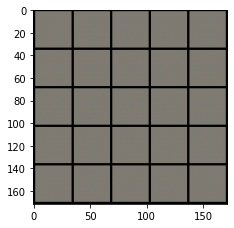

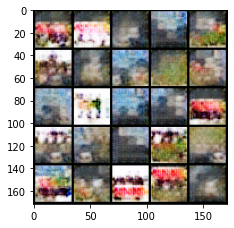

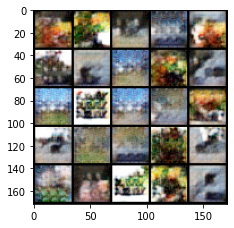

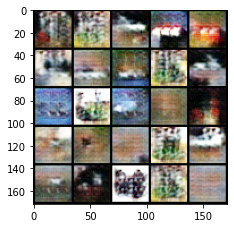

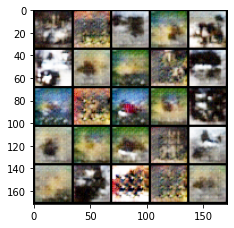

In [ ]:
# NOTE: Uses validation images from fitting, so 
#      FAILS IF n_cols * n_rows > 25

n_cols = 5
n_rows = 5
epochs = [0,100,200,350,499]
averaging = False

# ============ Show epoch images ============ 
# for ep in 'epochs', get n_cols * n_rows images
n_imgs = n_cols * n_rows
imgs = []
for ep in epochs:
  if not averaging:
    epoch_img = img_history[ep]
    imgs = epoch_img.narrow(0,0,n_imgs)
  else:
    epoch_avg_img = avgmodel_image_history[ep]
    imgs = epoch_avg_img.narrow(0,0,n_imgs)
  print("Epoch " + str(ep) + ":")
  my_show_tensor_images(imgs, num_cols = n_cols, num_rows = n_rows, unnorm_mean=unnorm_means, unnorm_var=unnorm_vars)

### Vis: Many images, last epoch

In [62]:
n_cols = 5
n_rows = 5
# Useful for fixing noise
fixed_noise = make_noise(n_cols * n_rows, z_dim, device=device)

With averaging:
Without averaging:


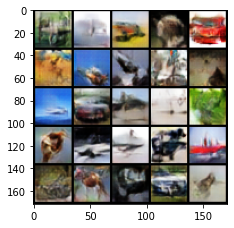

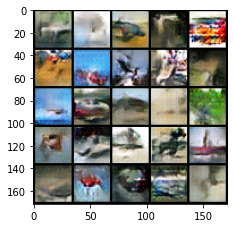

In [78]:
no_averaging = True
averaging = True

def show_many_images(n_cols, n_rows, no_averaging = False, averaging=False, noise = None):
  # get validation noise
  n_imgs = n_cols * n_rows
  if noise is None:
    temp_validation_noise = make_noise(n_imgs, z_dim, device=device)
  else:
    temp_validation_noise = noise
  
  if averaging:
    img_set = gen2(temp_validation_noise)
    print("With averaging:")
    my_show_tensor_images(img_set, num_cols=n_cols, num_rows=n_rows, unnorm_mean=unnorm_means, unnorm_var=unnorm_vars)
  
  if no_averaging:
    img_set = gen(temp_validation_noise)
    print("Without averaging:")
    my_show_tensor_images(img_set, num_cols=n_cols, num_rows=n_rows, unnorm_mean=unnorm_means, unnorm_var=unnorm_vars)

# to run with same noise and dim on multiple models, run this box without re-running the previous one
#   and set "noise = fixed_noise" in the args
# to use random noise, set "noise = None" or remove the noise arg
show_many_images(n_cols, n_rows, no_averaging=no_averaging, averaging=averaging, noise=fixed_noise)

## Inception Score


In [ ]:
# =========================================================================== #
#                  SET VALIDATION STUFF                                       #
# =========================================================================== #
test_size = 1024

from inception_score import inception_score
torch.manual_seed(0)
validation_noise = make_noise(test_size, z_dim, device=device)  # so we have a fixed validation noise
torch.manual_seed(int(time.time()))  # this should be random enough for fitting


valimg = gen(validation_noise)
avgimg = gen2(validation_noise)
test_score = inception_score(valimg, cuda=torch.cuda.is_available(), batch_size=batch_size, resize=True, n_sec=8)
avg_test_score = inception_score(avgimg, cuda=torch.cuda.is_available(), batch_size=batch_size, resize=True, n_sec=8)

print(test_score)
print(avg_test_score)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



(2.087597933686677, 0.11609281625515613)
(1.9230710314301538, 0.04840346009221634)


## Frechet Inception Distance (to CIFAR-10)

### FID with untrained model but Right number of classes (broken kinda)

In [ ]:
from torch.utils.data import RandomSampler
from scipy.linalg import sqrtm
import numpy as np
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize

FID_SAMPLE_SIZE = 10000
N_CLASSES = 10

def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)

def get_FID(data1, data2):
    # calculate data set statistics
    mu1, sigma1 = data1.mean(axis=0), np.cov(data1, rowvar=False)
    print(mu1)
    print(sigma1)
    mu2, sigma2 = data2.mean(axis=0), np.cov(data2, rowvar=False)
    print(mu2)
    print(sigma2)
    sqsumdiff = np.sum((mu1 - mu2) ** 2.0)
    covm = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covm):
        covm = covm.real
    # calculate score
    fid = sqsumdiff + np.trace(sigma1 + sigma2 - (2.0 * covm))
    return fid

# data is the set of images
def frechet_inception_distance(data1, data2, cuda=False, batch_size=32, resize=False, print_tag=False):
    N1 = len(data1)
    N2 = len(data2)
    data1 = np.array(data1).astype('float32')
    data2 = np.array(data2).astype('float32')
    # Do this in batches:
    """
    data1 = scale_images(data1, (299,299,3))
    data2 = scale_images(data2, (299,299,3))
    data1 = preprocess_input(data1)
    data2 = preprocess_input(data2)
    """
    loader1 = torch.utils.data.DataLoader(data1, batch_size=batch_size)
    loader2 = torch.utils.data.DataLoader(data2, batch_size=batch_size)
    # set up Inception V3 model
    model = InceptionV3(classes=N_CLASSES, weights=None)

    # Do predictions
    all_pyx1 = np.zeros((N1,N_CLASSES))
    for i, batch in enumerate(loader1, 0):
        if print_tag and i % 10 == 0:
            print("Batch " + str(i))
        batch_size_i = batch.size()[0]
        if print_tag and i % 10 == 0:
            print("Built batch")
        # actual prediction:                  Use batch_size_i to handle uneven batch
        # do batch processing
        batch = preprocess_input(scale_images(batch, (299,299,3)))
        all_pyx1[i*batch_size:i * batch_size + batch_size_i] = model.predict(batch)
        if print_tag and i % 10 == 0:
            print("Predicted batch")
    all_pyx2 = np.zeros((N2,N_CLASSES))
    print("DATA2===================")
    for i, batch in enumerate(loader2, 0):
        if print_tag and i % 10 == 0:
            print("Batch " + str(i))
        batch_size_i = batch.size()[0]
        if print_tag and i % 10 == 0:
            print("Built batch")
        # actual prediction:                  Use batch_size_i to handle uneven batch
        # do batch processing
        batch = preprocess_input(scale_images(batch, (299,299,3)))
        all_pyx2[i*batch_size:i * batch_size + batch_size_i] = model.predict(batch)
        if print_tag and i % 10 == 0:
            print("Predicted batch")

    return get_FID(all_pyx1, all_pyx2)

### Define FID

In [ ]:
from torch.utils.data import RandomSampler
from scipy.linalg import sqrtm
import numpy as np

FID_SAMPLE_SIZE = 10000

class IgnoreLabelDataset(torch.utils.data.Dataset):
    def __init__(self, orig):
        self.orig = orig

    def __getitem__(self, index):
        return self.orig[index][0]

    def __len__(self):
        return len(self.orig)

def get_FID(data1, data2):
    # calculate data set statistics
    mu1, sigma1 = data1.mean(axis=0), np.cov(data1, rowvar=False)
    mu2, sigma2 = data2.mean(axis=0), np.cov(data2, rowvar=False)
    sqsumdiff = np.sum((mu1 - mu2) ** 2.0)
    covm = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covm):
        covm = covm.real
    # calculate score
    fid = sqsumdiff + np.trace(sigma1 + sigma2 - 2.0 * covm)
    return fid

# data is the set of images
def frechet_inception_distance(data1, data2, cuda=False, batch_size=32, resize=True, print_tag=False):
    N1 = len(data1)
    N2 = len(data2)
    # Set up CUDA option
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("You should use cuda=True, you can do it!")
        dtype = torch.FloatTensor
    # set up data loader
    loader1 = torch.utils.data.DataLoader(data1, batch_size=batch_size)
    loader2 = torch.utils.data.DataLoader(data2, batch_size=batch_size)
    # set up Inception V3 model
    model = torchvision.models.inception_v3(pretrained=True, transform_input=False).type(dtype)
    model.eval()
    up = torch.nn.Upsample(size=(299,299), mode='bilinear', align_corners=False).type(dtype)

    # helpful prediction function
    def predict(x):
        if resize:
            x = up(x)
        x = model(x)
        return torch.nn.functional.softmax(x).data.cpu().numpy()

    # Do predictions
    all_pyx1 = np.zeros((N1,1000))
    for i, batch in enumerate(loader1, 0):
        if print_tag:
            print("Batch " + str(i))
        batch = batch.type(dtype)
        batchv = torch.autograd.Variable(batch)
        batch_size_i = batch.size()[0]
        if print_tag:
            print("Built batch")
        # actual prediction:                  Use batch_size_i to handle uneven batch
        all_pyx1[i*batch_size:i * batch_size + batch_size_i] = predict(batchv)
        if print_tag:
            print("Predicted batch")
    all_pyx2 = np.zeros((N2,1000))
    for i, batch in enumerate(loader2, 0):
        if print_tag:
            print("Batch " + str(i))
        batch = batch.type(dtype)
        batchv = torch.autograd.Variable(batch)
        batch_size_i = batch.size()[0]
        if print_tag:
            print("Built batch")
        # actual prediction:                  Use batch_size_i to handle uneven batch
        all_pyx2[i*batch_size:i * batch_size + batch_size_i] = predict(batchv)
        if print_tag:
            print("Predicted batch")

    return get_FID(all_pyx1, all_pyx2)

### Get FID from generator and sample

In [ ]:
# First, generator random sample
FID_noise = make_noise(FID_SAMPLE_SIZE, z_dim, device=device)
FID_fake = gen(FID_noise)

# Second, "true" sample (e.g. from CIFAR-10)
cifar_data = CIFAR10(root='.', download=True, 
                     transform=transforms.Compose([
                                transforms.Resize(32),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ]))

subset_data = random_split(cifar_data.data, lengths=[FID_SAMPLE_SIZE, len(cifar_data)-FID_SAMPLE_SIZE])

FID_real = torch.tensor(subset_data[0]).reshape(-1,3,32,32).type(torch.float32)
#print(cifar_data.data)

var = torch.tensor((0.5, 0.5, 0.5)).view(1, 3, 1, 1)
mean = torch.tensor((0.5, 0.5, 0.5)).view(1, 3, 1, 1)
image_unflat = FID_fake.detach().cpu()
FID_fake = image_unflat.mul_(var).add_(mean)
FID_fake = 255 * FID_fake

FID_real = FID_real

FID_fake = torch.tensor(np.array(FID_fake).transpose(0,2,3,1))
print(FID_fake.shape)
FID_real = torch.tensor(np.array(FID_real).transpose(0,2,3,1))



# Then, evaluate
FID = frechet_inception_distance(FID_real, FID_real,
                                cuda=torch.cuda.is_available(), batch_size=32, resize=True)
print(FID)

Files already downloaded and verified
torch.Size([10000, 32, 32, 3])
torch.Size([32, 32, 32, 3])


RuntimeError: ignored

# Do Things For A Lot of Checkpoints

## Plot many inception scores on the same graph

========= Checkpoint found! Resuming training from last checkpoint at ======== 
/content/drive/My Drive/datafor6140/DCGAN_alt_batchNorm_Adam.pt
Loading checkpoint...
Loaded img_history and inception_scores
========= Checkpoint found! Resuming training from last checkpoint at ======== 
/content/drive/My Drive/datafor6140/DCGAN_alt_batchNorm_extraAdam.pt
Loading checkpoint...
Loaded img_history and inception_scores
========= Checkpoint found! Resuming training from last checkpoint at ======== 
/content/drive/My Drive/datafor6140/DCGAN_alt_batchnorm_extrapastAdam.pt
Loading checkpoint...
Loaded img_history and inception_scores


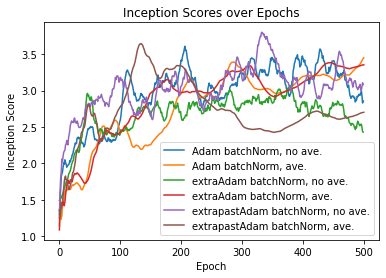

In [12]:
# list of checkpoint files to load (file location is from CHECKPOINT_PATH) and labels
# items in the list should be (FILENAME, label, batchnorm)
#                         e.g. ("DCGAN_alt_batchnorm_SGD.pt","SGD with batch norm")
checkpoints = [("DCGAN_alt_batchNorm_Adam.pt", "Adam batchNorm"),
               ("DCGAN_alt_batchNorm_extraAdam.pt", "extraAdam batchNorm"),
               ("DCGAN_alt_batchnorm_extrapastAdam.pt", "extrapastAdam batchNorm")]

"""list:
 DCGAN_alt_batchNorm_Adam.pt		         DCGAN_extrapast_noNorm_SGD.pt
 DCGAN_alt_batchNorm_extraAdam.pt	       DCGAN_extrapast_ourNorm_SGD.pt
 DCGAN_alt_batchNorm_SGD.pt	          	 DCGAN_sim_BatchNorm_Adam.pt
 DCGAN_alt_noNorm_extraAdam.pt	      	 DCGAN_sim_BatchNorm_SGD.pt
 DCGAN_alt_noNorm_SGD.pt	            	 DCGAN_sim_noNorm_Adam_old.pt
 DCGAN_alt_norm_Adam.pt		            	 DCGAN_sim_noNorm_Adam.pt
 DCGAN_alt_norm_extraAdam.pt	        	 DCGAN_sim_noNorm_SGD_old.pt
 DCGAN_alt_ourNorm_SGD.pt	            	 DCGAN_sim_noNorm_SGD.pt
 DCGAN_extra_noNorm_SGD_old.pt	      	 DCGAN_sim_ourNorm_Adam.pt
 DCGAN_extra_noNorm_SGD.pt	          	 DCGAN_sim_ourNorm_SGD.pt
 DCGAN_extrapast_BatchNorm_SGD.pt     	 DCGAN_simul_extraadam_batchnorm.pt
 DCGAN_extrapast_noNorm_SGD_old.pt    	 Resnet_alt_Norm_extraAdam.pt
"""

""" alt vs. sim, batchnorm
[("DCGAN_alt_batchNorm_Adam.pt", "Adam batchNorm"),
               ("DCGAN_alt_batchNorm_extraAdam.pt", "extraAdam batchNorm"),
               ("DCGAN_alt_batchNorm_SGD.pt", "SGD batchNorm"),
               ("DCGAN_sim_BatchNorm_Adam.pt", "Sim Adam batchNorm"),
               ("DCGAN_sim_BatchNorm_SGD.pt", "Sim SGD batchNorm"),
               ("DCGAN_simul_extraadam_batchnorm.pt", "Sim extraAdam batchNorm")]

"""
withAverage = True       # include averaging inception score
withNoAverage = True     # include non-averaging inception score
IS_smoothness = 5        # smoothing value for graph
                         # 0 yields true function, higher smooths the graph more (must be int)

for (checkpoint_file, checkpoint_label) in checkpoints:
  checkpoint_filepath = CHECKPOINT_PATH + checkpoint_file
  # load checkpoint
  print(f"========= Checkpoint found! Resuming training from last checkpoint at ======== \n{checkpoint_filepath}")
  print("Loading checkpoint...")
  checkpoint = torch.load(checkpoint_filepath, map_location=torch.device('cpu'))
  """print("Checkpoint loaded successfully! Info:")
  last_epoch = checkpoint['epoch'] + 1
  print(f"\tLast epoch: {last_epoch - 1}")
  disc.load_state_dict(checkpoint['disc_state_dict'])
  gen.load_state_dict(checkpoint['gen_state_dict'])
  disc2.load_state_dict(checkpoint['disc2_state_dict'])
  gen2.load_state_dict(checkpoint['gen2_state_dict'])
  disc_opt.load_state_dict(checkpoint['disc_opt_state_dict'])
  gen_opt.load_state_dict(checkpoint['gen_opt_state_dict'])
  print(f"\tLoaded discriminator and generator's old weight and state_dict")
  generator_losses = checkpoint['generator_losses']
  disc_losses = checkpoint['disc_losses']
  gen2_losses = checkpoint['gen2_losses']
  disc2_losses = checkpoint['disc2_losses']
  print(f"\tLoaded losses history.")
  step = checkpoint['step']
  print(f"\tLast step: {step}")"""
  img_history = checkpoint['img_history']
  inception_scores = checkpoint['inception_scores']
  avgmodel_image_history = checkpoint['avgmodel_image_history'] 
  avgmodel_inception_scores = checkpoint['avgmodel_inception_scores'] 
  print("Loaded img_history and inception_scores")
  """print("===================== FINISHED LOADING LAST CHECKPOINT. TRAINING ===========")"""
  # smooth and plot scores
  if withNoAverage:
    smooth_inception_scores = smooth_vals(inception_scores, IS_smoothness)
    plt.plot(
      range(len(smooth_inception_scores)),
      smooth_inception_scores,
      label=checkpoint_label + ", no ave."
    )
  if withAverage:
    smooth_ave_ISs = avgmodel_inception_scores # smooth_vals(avgmodel_inception_scores, IS_smoothness)
    plt.plot(
      range(len(smooth_ave_ISs)),
      smooth_ave_ISs,
      label=checkpoint_label + ", ave."  
    )

plt.xlabel("Epoch")
plt.ylabel("Inception Score")
plt.title("Inception Scores over Epochs")
plt.legend()
plt.show()
